# fix tree, for the last time!

### Test case

In [1]:
import tree.ctutils as ctu

def link_circle_up(x, y, r, ax, finish=0):
    """
    Given two points, draw circle at the first point and link it to the second point
    without drawing the second point by default (so that it can repeat to build a long thread of bids).
    for the last point, pass the radius of the last circle to the argument 'finish'
    
    For example,

    fig = plt.figure()
    ax = fig.add_subplot(111)
    xpos = [1,1] &  ypos = [2,4]
    link_circle(xpos, ypos, 10, ax)

    xpos = [1,2] & ypos = [4,6]
    link_circle(xpos, ypos, 30, ax, finish=30)
    fig.show()
    """
    ax.plot(x[0], y[0], 'o', ms=r, lw=2,  alpha=0.7, mfc='orange')
    ax.plot(x, y, '-', c='black',alpha=0.7)
    if finish > 0:
        ax.plot(x[1], y[1], 'o', ms=20, lw=2, alpha=0.7, mfc='orange')    

def get_xarr(n):
    import numpy as np
    arr=[]
    a=0
    for i in range(n):
        a += (-1)**i * i
        arr.append(a)
    return np.asarray(arr)  
        
def recursive_tree(idx, tt, nstep, ax, x0, y0, dx, mass_unit=1e10):
    import tree.draw_merger_tree as dmt
    prgs = ctu.get_progenitors(tt, idx)
    i_this_gal = np.where(tt['id'] == idx)
    m = np.sqrt(tt[i_this_gal]["mvir"] / mass_unit)
    #print("IDX:", idx, "prgs: ",prgs, "mass:", m, i_this_gal)
    nprg = len(prgs)
    if nstep == 0:
        return 
    else:
        if nprg == 0:
            return
        else:
            if nprg > 1:
                #dx *= 1.1
                dx += 0.5
#                print("Branch!", nprg)

            #xarr = get_xarr(nprg) * dx + x0
            xarr = np.arange(nprg) * dx + x0
            for i, x in zip(prgs, xarr):
                link_circle_up([x0, x], [y0, y0 + 1], m, ax)
                recursive_tree(i, tt, nstep - 1, ax, x, y0 + 1, dx, mass_unit=mass_unit)


def extract_main_tree(treedata, idx=None, verbose=False):
    """
        Returns a single branch/trunk of tree following only the main progenitors.
        Works with both alltrees or atree.
        Search until no progenitor is found. Doesn't matter how long the given tree is. 
        Only earlier snapshots are searched for.
    """
    
    if idx == None:
        idx = treedata['id'][0]
        if verbose:
            print("No idx is given")
            print("idx = ", idx)

    
    nprg = 1
    ind_list=[np.where(treedata['id'] == idx)[0][0]]
    
    # main progenitor = mmp.
    while nprg > 0:        
        idx = ctu.get_progenitors(treedata, idx, main=True)
#        print(idx)
        ind_list.append(np.where(treedata['id'] == idx[0])[0][0])

        nprg = ctu.get_npr(treedata, idx[0])

    return treedata[ind_list]



def plot_atree(atree, galid):
    fig, ax = plt.subplots(1)
    ax.scatter(atree['aexp'], np.log10(atree['m']))
    ax.title(galid)
    plt.savefig(wdir + "mergertrees/" + sidgal + '.png')

In [9]:
###############################################################################
import matplotlib.pyplot as plt
from tree import treemodule
from tree import treeutils
import pickle
import numpy as np

In [1]:
alltrees = treemodule.CTree()
wdir = './10002/'
is_gal = True

if is_gal:
    # Galaxy tree
    tree_path = 'GalaxyMaker/Trees/'
else:
    # halo tree
    tree_path = 'halo/Trees/'

load_extended_tree = True
    
if load_extended_tree:    
    try:
        alltrees = pickle.load(open(wdir + tree_path + "extended_tree.pickle", "rb" ))
        print("Loaded an extended tree")
    except:
        load_extended_tree = False

if not load_extended_tree:
    """
        info file of each snapshot are required.
    """
    alltrees = treemodule.CTree()
    alltrees.load(filename= wdir + tree_path + 'tree_0_0_0.dat')
    # Fix nout -----------------------------------------------------
    nout_max = alltrees.data['nout'].max()
    alltrees.data['nout'] += 187 - nout_max
    print("------ NOUT fixed")
    alltrees.data = ctu.augment_tree(alltrees.data, wdir, is_gal=is_gal)
    print("------ tree data extended")

alltrees =     
    
nout_fi = 187
nout_ini = 30


i_final = np.where(alltrees.data["nout"] == nout_fi)
ttt_sub = alltrees.data[i_final]

nouts = np.arange(nout_fi - nout_ini + 1)

final_gals = ttt_sub['id']
final_gals_org = ttt_sub['Orig_halo_id']

plt.ioff()

#figure(figsize=[6,6])
#ax = fig.add_subplot(211)

#aexps = np.unique(alltrees.data["aexp"])[:len(nouts)]
aexps = np.unique(alltrees.data["aexp"])[:-len(nouts):-1]
zreds = ["%.2f" % (1/i -1) for i in aexps]

FileNotFoundError: [Errno 2] No such file or directory: './GalaxyMaker/Trees/tree_0_0_0.dat'

In [7]:
import os
if not os.path.isdir(wdir + "mergertrees/"):
    os.mkdir(wdir + "mergertrees/")


fig, ax = plt.subplots(1,2)
fig.set_size_inches([12,6])
for galid in final_gals:
    sidgal = str(galid).zfill(5)      
    
    #print(zreds)
    atree = ctu.extract_a_tree(alltrees.data, galid)
    mtree = extract_main_tree(atree)
    
    ax[0].scatter(atree['aexp'], np.log10(atree['m']), edgecolors='none', alpha=0.3)
    ax[0].scatter(mtree['aexp'], np.log10(mtree['m']), edgecolors='none', alpha=0.6,
                  facecolors='red')
    ax[0].set_xlim([0.15,1.1])
    ax[0].set_xticks(aexps[0:151:20])
    ax[0].set_xticklabels(zreds[0:151:20])
    ax[0].set_title(galid)
    
    recursive_tree(galid, atree, 150, ax[1], 0, 0, 0.8, mass_unit=2e8)
    
    # y axis label (redshift)
    ax[1].set_ylabel("Redshift")
    ax[1].set_ylim([-5,155])
    ax[1].set_yticks(range(0,151,10))
    ax[1].set_yticklabels(zreds[0:151:10])
    #plt.yticks(range(0,151,10), zreds[0:151:10])
    ax[1].set_title(sidgal + ", " + str(atree[0]['Orig_halo_id']))
    #fig.show()
    plt.savefig(wdir + "mergertrees/" + sidgal + '.png')
    ax[0].clear()
    ax[1].clear()
    
    #plt.close()


plt.close()

/home/hoseung/.local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/home/hoseung/.local/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


###  158132, 93 

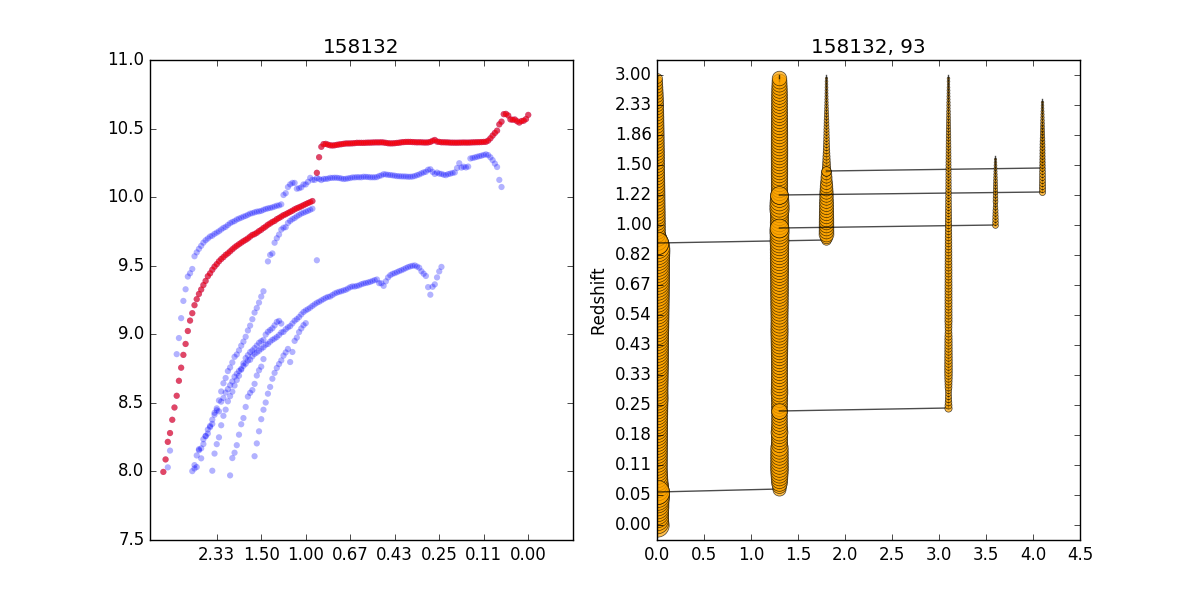

In [3]:
from IPython.display import Image
Image(filename='./10002/mergertrees/158132.png') 

CASE 1)
The second galaxy branch makes sense. But the main progenitor does not. 
There might be another galaxy (not in this tree), and CT might have failed to achieve all:all matching.
This is the only case in 10002. 

CASE 2)
There is no case where there is wrong main progenitor when possibly 'real' progenitor is also in the tree.
For example, 29176/270444 is such a case.

However, these will result in sudden change in lambda. (can be categorized as both major or minor merger..)

## CASE 2 might be easier to solve. 

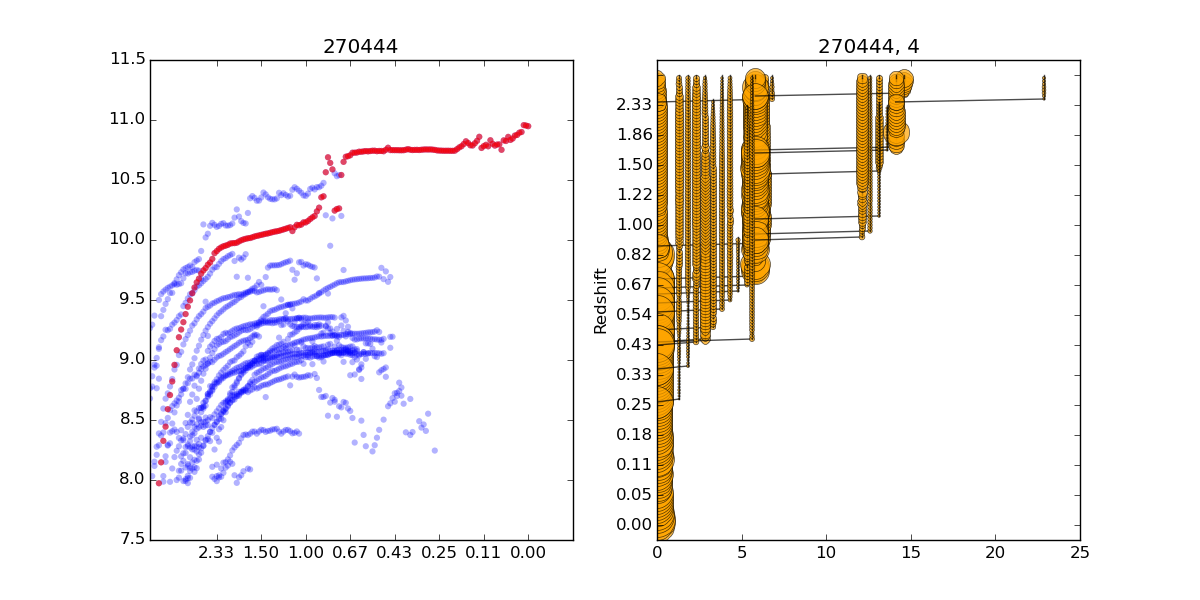

In [4]:
Image(filename='./29176/mergertrees/270444.png') 

In [5]:
alltree = ctu.load_tree('./29176/', is_gal=True)

Loaded an extended tree


In [6]:
atree = ctu.extract_a_tree(alltree.data, 270444)

In [7]:
sub = atree[atree['m'] > 1e10]

In [16]:
print(sub['id'][sub['nout'] == 103])

[171034 171035]


In [33]:
import importlib
importlib.reload(ctu)

<module 'tree.ctutils' from '/home/hoseung/Work/pyclusterevol/tree/ctutils.py'>

extract_main_tree 고쳤음. 

In [34]:
branch1 = ctu.extract_main_tree(sub, idx=171034, no_subset=True)
branch2 = ctu.extract_main_tree(sub, idx=171035, no_subset=True)

In [22]:
ind_list=[np.where(sub['id'] == 171034)[0][0]]
print(ind_list)

[84]


In [42]:
branch2['nout']

array([103, 102, 101, 100,  99])

In [44]:
fig, ax=plt.subplots(2)
ax[0].scatter(branch1['nout'], np.log10(branch1['m']), c='r')#, c=sub[''])
ax[0].scatter(branch2['nout'], np.log10(branch2['m']), c='b')#, c=sub[''])
ax[1].scatter(sub['nout'], np.log10(sub['m']), c='b')#, c=sub[''])
plt.show()

In [11]:
sub.dtype

dtype([('aexp', '<f8'), ('id', '<i8'), ('desc_aexp', '<i8'), ('desc_id', '<i8'), ('nprog', '<i8'), ('pid', '<i8'), ('upid', '<i8'), ('desc_pid', '<i8'), ('phantom', '<i8'), ('sam_mvir', '<f8'), ('mvir', '<f8'), ('rvir', '<f8'), ('rs', '<i8'), ('vrms', '<f8'), ('mmp', '<f8'), ('aexp_last_MM', '<f8'), ('vmax', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<i8'), ('jx', '<i8'), ('jy', '<i8'), ('jz', '<f8'), ('spin', '<i8'), ('b_id', '<i8'), ('d_id', '<i8'), ('tree_root_id', '<i8'), ('Orig_halo_id', '<i8'), ('nout', '<i8'), ('next_coprogenitor_d_id', '<i8'), ('last_progenitor_d_id', '<f8'), ('np', '<i4'), ('m', '<f4'), ('r', '<f4'), ('tvir', '<f4'), ('cvel', '<f4'), ('sig', '<f4'), ('sigbulge', '<f4'), ('mbulge', '<f4')])